In [6]:
REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14_reg"


# Dense Matching

In [7]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

# Utilities

In [8]:
# references: https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb 
# https://github.com/salihmarangoz/dinov2/blob/main/notebooks/matching_example/dinov2_matching.ipynb

from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    image = Image.fromarray(rgb_image_numpy)
    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale
  
  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask
  
  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()
  
  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col
  
  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens
  
  def get_combined_embedding_visualization(self, tokens1, token2, grid_size1, grid_size2, mask1=None, mask2=None, random_state=20):
    pca = PCA(n_components=3, random_state=random_state)
    
    token1_shape = tokens1.shape[0]
    if mask1 is not None:
      tokens1 = tokens1[mask1]
    if mask2 is not None:
      token2 = token2[mask2]
    combinedtokens= np.concatenate((tokens1, token2), axis=0)
    reduced_tokens = pca.fit_transform(combinedtokens.astype(np.float32))
    
    
    if mask1 is not None and mask2 is not None:
      resized_mask = np.concatenate((mask1, mask2), axis=0)
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    elif mask1 is not None and mask2 is None:
      return sys.exit("Either use both masks or none")
    elif mask1 is None and mask2 is not None:
      return sys.exit("Either use both masks or none")

    
    print("tokens1.shape", tokens1.shape)
    print("token2.shape", token2.shape)
    print("reduced_tokens.shape", reduced_tokens.shape)
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
        
    rgbimg1 = normalized_tokens[0:token1_shape,:]
    rgbimg2 = normalized_tokens[token1_shape:,:]
    
    rgbimg1 = rgbimg1.reshape((*grid_size1, -1))
    rgbimg2 = rgbimg2.reshape((*grid_size2, -1))
    return rgbimg1,rgbimg2




In [9]:
# Load image and mask
image1 = cv2.cvtColor(cv2.imread('Images/asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask1 = cv2.imread('Images/asd1_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127


image2 = cv2.cvtColor(cv2.imread('Images/asd2.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask2 = cv2.imread('Images/asd2_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127


# Init Dinov2Matcher
dm = Dinov2Matcher(repo_name=REPO_NAME, model_name=MODEL_NAME,half_precision=False)

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
features1 = dm.extract_features(image_tensor1)

image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(image2)
features2 = dm.extract_features(image_tensor2)






Using cache found in /home/dino_user/.cache/torch/hub/facebookresearch_dinov2_main


tokens1.shape (368, 768)
token2.shape (428, 768)
reduced_tokens.shape (3040, 3)
image1.shape: (568, 700, 3)
mask1.shape: (568, 700)
image_tensor1.shape: torch.Size([3, 448, 546])
grid_size1: (32, 39)
resize_scale1: 1.2681159420289856


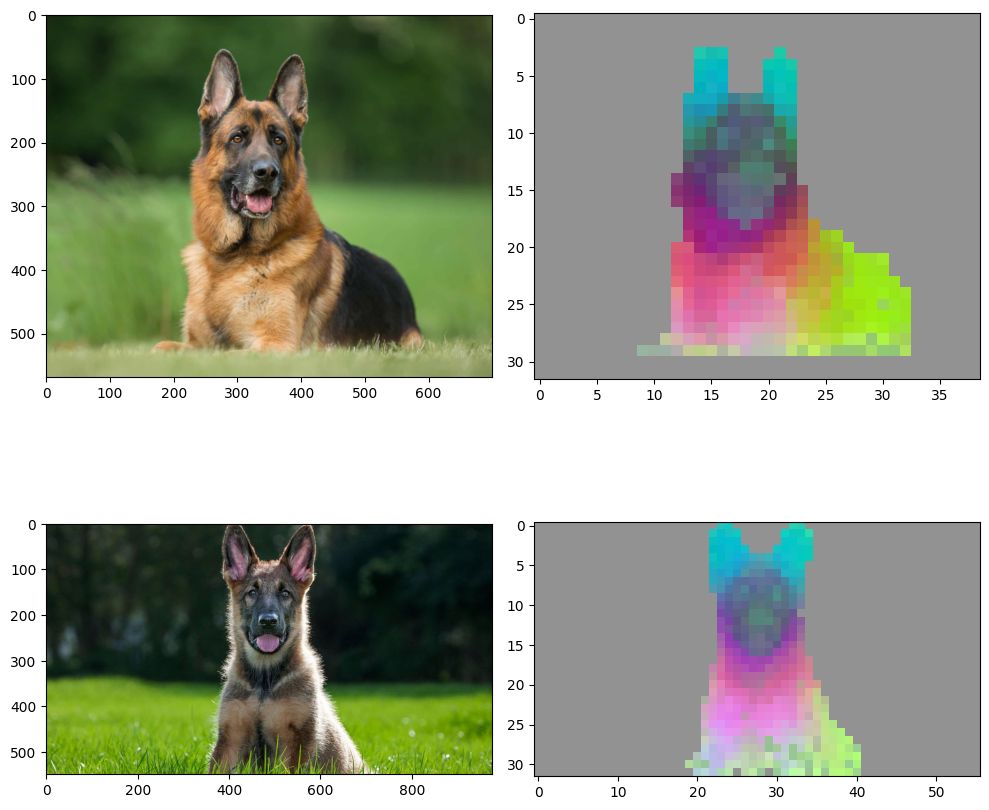

In [10]:


# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(image1)
resized_mask = dm.prepare_mask(mask1, grid_size1, resize_scale1)
# vis_image = dm.get_embedding_visualization(features1, grid_size1, resized_mask)

ax3.imshow(image2)
resized_mask2 = dm.prepare_mask(mask2, grid_size2, resize_scale2)
# vis_image2 = dm.get_embedding_visualization(features2, grid_size2, resized_mask2)

#use mask
vis_image3, vis_image4 =  dm.get_combined_embedding_visualization( features1, features2, grid_size1, grid_size2, resized_mask, resized_mask2)
#don't use mask
# vis_image3, vis_image4 =  dm.get_combined_embedding_visualization( features1, features2, grid_size1, grid_size2, )

ax2.imshow(vis_image3)
ax4.imshow(vis_image4)


fig.tight_layout()

# More info
print("image1.shape:", image1.shape)
print("mask1.shape:", mask1.shape)
print("image_tensor1.shape:", image_tensor1.shape)
print("grid_size1:", grid_size1)
print("resize_scale1:", resize_scale1)